In [1]:
import os
import numpy as np
import pandas as pd
import glob
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt 
from matplotlib.pyplot import imshow
from PIL import Image
from bs4 import BeautifulSoup
from collections import Counter
from shutil import copyfile
import random
import pickle

% matplotlib inline

## Look at a few images

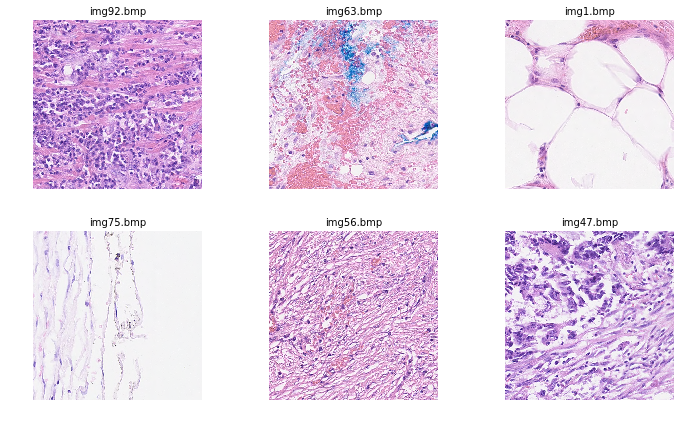

In [2]:
loc='/home/rbbidart/project/rbbidart/cancer_hist/CRCHistoPhenotypes_2016_04_28/Classification'
all_images=glob.glob(loc+'/**/*.bmp', recursive=True)
image_locs = np.random.choice(all_images, 6)

f = plt.figure(figsize=(10,6)) 
for i in range(len(image_locs)):
    sp = f.add_subplot(2, len(image_locs)//2, i+1)
    sp.axis('Off')
    sp.set_title(image_locs[i].rsplit('/', 1)[-1], fontsize=10)
    image = np.asarray(Image.open(image_locs[i]))
    plt.tight_layout()
    plt.imshow(image)

## Test Train Valid Split

In [8]:
def get_points_mat(labels_list):
    nuclei_type_list = ['epithelial', 'fibroblast', 'inflammatory', 'others', 'detection']
    points = {}
    
    for label_loc in labels_list:
        name = label_loc.rsplit('/', 1)[1].rsplit('_', 1)[0]
        nuclei_type = label_loc.rsplit('/', 1)[1].rsplit('_', 1)[1].rsplit('.', 1)[0]
        mat = scipy.io.loadmat(label_loc)
        points[nuclei_type] = np.round(mat['detection'])
    return points



def ttv_split(data_loc, out_dir, valid_proportion, test_proportion):
    all_images=glob.glob(data_loc+'/Classification/**/*.bmp', recursive=True)
    all_labels=glob.glob(data_loc+'/**/*.mat', recursive=True)
    num_images=len(all_images)
    num_labels=len(all_labels)
    print('num_images: ', num_images)
    print('num_labels: ', num_labels)

    # randomize the order for ttv split and divide into test train valid
    random.shuffle(all_images)
    ttv_files = {}
    ttv_files['train'] = all_images[0:int(np.ceil(num_images*(1-valid_proportion-test_proportion)))]
    ttv_files['test'] = all_images[int(np.ceil(num_images*(1-valid_proportion-test_proportion))) : int(np.ceil(num_images*(1-valid_proportion)))]
    ttv_files['valid'] = all_images[int(np.ceil(num_images*(1-valid_proportion))):]
    
    for ttv_dir, file_list in ttv_files.items():
        print(ttv_dir, len(file_list))
        for file in file_list:
            # Copy the image to the correct folder
            name = file.rsplit('/', 1)[1]
            new_loc = os.path.join(out_dir, ttv_dir, 'images')
            if not os.path.exists(new_loc):
                os.makedirs(new_loc)
            copyfile(file, os.path.join(new_loc , name))

            # also copy the labels
            labels_list = [loc for loc in all_labels if loc.rsplit('/', 1)[1].rsplit('_', 1)[0].rsplit('.', 1)[0] == name.rsplit('.', 1)[0]]
            name_label = name.rsplit('.', 1)[0]
            points = get_points_mat(labels_list)
            new_loc = os.path.join(out_dir, ttv_dir, 'labels')
            if not os.path.exists(new_loc):
                os.makedirs(new_loc)                
            with open(os.path.join(new_loc, name_label+'.pickle'), 'wb') as handle:
                pickle.dump(points, handle, protocol=pickle.HIGHEST_PROTOCOL)

    

# data_loc = '/home/rbbidart/project/rbbidart/cancer_hist/CRCHistoPhenotypes_2016_04_28/'
# out_dir = '/home/rbbidart/project/rbbidart/cancer_hist/crc_ttv_split'

# ttv_split(data_loc=data_loc, out_dir=out_dir, valid_proportion =.15, test_proportion=.25)

num_images:  100
num_labels:  500
test 25
train 60
valid 15


## Create dataset for classifier

* Make the dataset consisting of all the detected points. 
* 4 Classes, plus the dected and not classified points.
* Add in non-nuclei points by taking some at least 5 pixels from the true center, because we still want points near the edge of the nuclei. We are training a classifier for the center. Double number of true points. 
* ? The detected but not classified will not hurt the classifier. We can do argmax excluding this. 
* Keras dir format

In [38]:
def extract_regions_crc(data_loc, out_dir, im_size, prop_neg=1):
    im_size=int(im_size)
    images_loc = os.path.join(data_loc, 'images')
    labels_loc = os.path.join(data_loc, 'labels')
    all_images=glob.glob(os.path.join(images_loc, '*'))
    all_labels=glob.glob(os.path.join(images_loc, '*'))

    num_images = len(all_images)
    print('num_images: ', num_images)
    
    for image_file in all_images:
        img_name = image_file.rsplit('/', 1)[1].rsplit('.', 1)[0]
        print(img_name)
        
        # load the points
        point_loc = os.path.join(labels_loc, img_name+".pickle")
        point_dict = pickle.load( open(point_loc, "rb" ))
        
        # load the image
        image = np.array(Image.open(image_file))
        im_name = image_file.rsplit('.', 1)[-2].rsplit('/', 1)[1].rsplit('_', 1)[0].replace(" ", "_")
        delta=int((im_size)/2)

        # pad the image so you can always take the proper sized image
        pad_width=int((im_size)/2)
        image = np.lib.pad(image, ((pad_width, pad_width), (pad_width, pad_width), (0,0)), 'constant', constant_values=(0, 0))

        ############### Get all of the nuclei
        num_pos = 0
        
        # detection nuclei includes all included in the labeled classes. Change this to only detected ones 
        # so not created twice
        all_nuclei = point_dict['detection'].tolist()
        all_labeled_nuclei = np.vstack([point_dict['epithelial'], point_dict['fibroblast'], 
                                       point_dict['inflammatory'], point_dict['others']]).tolist()

        
        only_detection_nuclei = [row for row in all_nuclei if row not in all_labeled_nuclei]
        point_dict['detection'] = only_detection_nuclei
        print('only_detection_nuclei', len(point_dict['detection']))
        print('all_labeled_nuclei', len(all_labeled_nuclei))
        print(point_dict)

        for nuclei_type, point_list in point_dict.items():
            new_loc = os.path.join(out_dir, nuclei_type)
            if not os.path.exists(new_loc):
                os.makedirs(new_loc)
            for point in point_list:
                x=int(point[0]) + delta
                y=int(point[1]) + delta

                seg_image = image[y-delta:y+delta, x-delta:x+delta,:]
                out_name=str(nuclei_type)+'_'+str(num_pos)+'_'+im_name+'.jpg'

                outfile=os.path.join(out_dir, out_name)
                scipy.misc.imsave(outfile, seg_image)
                num_pos = num_pos+1
                print(num_pos)
            
        # Get Negatives. Evenly sample from every image:
        samples_needed = np.round(float(30000)/100)*prop_neg
        samp_taken = 0
        while (samp_taken < samples_needed):
            row = random.randint(pad_width, image.shape[0]-pad_width)
            col = random.randint(pad_width, image.shape[1]-pad_width)
            proposed_center = np.array([row, col])
            dists = np.sqrt(np.sum((all_nuclei - proposed_center) ** 2, axis=1))
            min_ind = np.argmin(dists)
            print(dists[min_ind])
            if (dists[min_ind] > 6):
                seg_image = image[row-delta:row+delta, col-delta:col+delta,:]
                out_name=str(0)+'_'+str(samp_taken)+'_'+im_name+'.jpg'
                outfile=os.path.join(out_dir, out_name)
                scipy.misc.imsave(outfile, seg_image)
                samp_taken=samp_taken+1
                print(samp_taken)

In [39]:
im_size = 128

data_loc = '/home/rbbidart/project/rbbidart/cancer_hist/crc_ttv_split/valid'
out_dir = '/home/rbbidart/project/rbbidart/cancer_hist/crc_128/valid'
extract_regions_crc(data_loc=data_loc, out_dir=out_dir, im_size=im_size, prop_neg=1)

data_loc = '/home/rbbidart/project/rbbidart/cancer_hist/crc_ttv_split/train'
out_dir = '/home/rbbidart/project/rbbidart/cancer_hist/crc_128/train'
extract_regions_crc(data_loc=data_loc, out_dir=out_dir, im_size=im_size, prop_neg=1)

data_loc = '/home/rbbidart/project/rbbidart/cancer_hist/crc_ttv_split/test'
out_dir = '/home/rbbidart/project/rbbidart/cancer_hist/crc_128/test'
extract_regions_crc(data_loc=data_loc, out_dir=out_dir, im_size=im_size, prop_neg=1)

num_images:  15
img35
only_detection_nuclei 0
all_labeled_nuclei 11
{'fibroblast': array([], shape=(0, 2), dtype=uint8), 'others': array([[ 269.,  196.],
       [ 250.,  208.],
       [ 291.,  207.],
       [ 342.,  229.],
       [  72.,  257.],
       [  66.,  288.],
       [ 487.,  144.],
       [ 450.,  394.],
       [ 206.,  473.]]), 'detection': [], 'inflammatory': array([[ 271.,  175.],
       [ 480.,  158.]]), 'epithelial': array([], shape=(0, 2), dtype=uint8)}
1
2
3
4
5
6
7
8
9
10
11
56.639209034
1
104.062481231
2
54.3783044973
3
77.3886296558
4
114.947814246
5
46.0977222865
6
110.027269347
7
40.2243707222
8
110.47624179
9
138.293166859
10
129.120099133
11
129.711217711
12
108.258948822
13
111.251966275
14
104.172933145
15
96.4209520799
16
63.6396103068
17
66.5732679084
18
118.697093477
19
117.64777941
20
61.8142378421
21
44.5533388199
22
63.7808748764
23
68.8839603972
24
116.777566339
25
15.2643375225
26
60.166435826
27
37.3363094052
28
149.214610545
29
38.6005181312
30
70.327

KeyboardInterrupt: 

In [ ]:
import sys
sys.path.insert(0, '/Users/rb/Google_Drive/Waterloo/projects/cancer_hist/src')
from functions import*

data_loc ='/Users/rb/Documents/waterloo/projects/cancer_hist/ExtractedNucleiROIs'
all_files=glob.glob(os.path.join(data_loc, '*'))
all_images = [loc for loc in all_files if loc.rsplit('.', 1)[-2][-4:] == 'crop']
image_locs = np.random.choice(all_images, 6)

#f = plt.figure(figsize=(20,30))
f = plt.figure(figsize=(12,15))

for i in range(0, len(image_locs)):
    image_loc = image_locs[i]
    xml_loc = image_loc.replace('crop.tif', 'key.xml')

    all_points = get_points_xml(xml_loc)
    point_list = all_points[:, 0:2]
    
    image = Image.open(image_loc)
    image2 = np.asarray(image).astype(int)
    for row in range(len(all_points)):
        if all_points[row, 2] == 1:
            color = [0, 0, 255]
        elif all_points[row, 2] == 2:
            color = [0, 255, 0]  
        elif all_points[row, 2] == 3:
            color = [255, 0, 0]
        image2[int(all_points[row, 0])-2:int(all_points[row, 0])+2, int(all_points[row, 1])-2:int(all_points[row, 1])+2, :] = color

    sp = f.add_subplot(3, len(image_locs)//3, i+1)
    sp.axis('Off')
    sp.set_title(image_loc.rsplit('/', 1)[-1], fontsize=10)
    plt.tight_layout()
    plt.imshow(image2.astype(np.uint8))

## Look at some annotated images